### setup

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import yaml

from myyololib.dataset import get_dataloader, preprocess_dataset
from myyololib.models import MyYOLOv8n, QYOLOv8n, NYOLOv8n

from myyololib.train_config import TrainConfig, FinetuneConfig
from myyololib.trainer import train
from myyololib.evaluator import evaluate
from myyololib.load_model import load_model, load_QAT_model, load_NPU_model
from myyololib.visualize import visualize_multiple_tensors, visualize_float_tensor_distribution, \
    visualize_tensor_distribution, visualize_multiple_poz, ActivationStatsCollector
from myyololib.npu_blocks import NConv2d
from myyololib.basic_blocks import DFL
from myyololib.qat_blocks import QConv2d, QConv
from myyololib.demo import demo


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model

In [3]:
train_loader, val_loader, coco_id2label, label2coco_category = get_dataloader()

loading annotations into memory...
Done (t=13.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [15]:
# model = load_model('checkpoints/yolov8n.pt', device)

In [4]:
model = load_model('checkpoints/yolov8n.pt', device)

Start matching keys...

Matching keys done.



In [3]:
model = load_model('checkpoints/relu_091214.pth', device)

Loaded .pth state_dict
Start matching keys...

Matching keys done.



In [4]:
# load QAT model with quantization config
with open('./config/qcfg_0928.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

Qmodel = load_model('checkpoints/qat_09272248.pt', device, model_type="qat", model_qcfg=loaded_cfg)

Start matching keys...

Matching keys done.



# Train

In [ ]:
Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)
# QAT model fine-tuning
train(Qmodel, train_loader, val_loader, device, FinetuneConfig)

# Visualize

## Weight

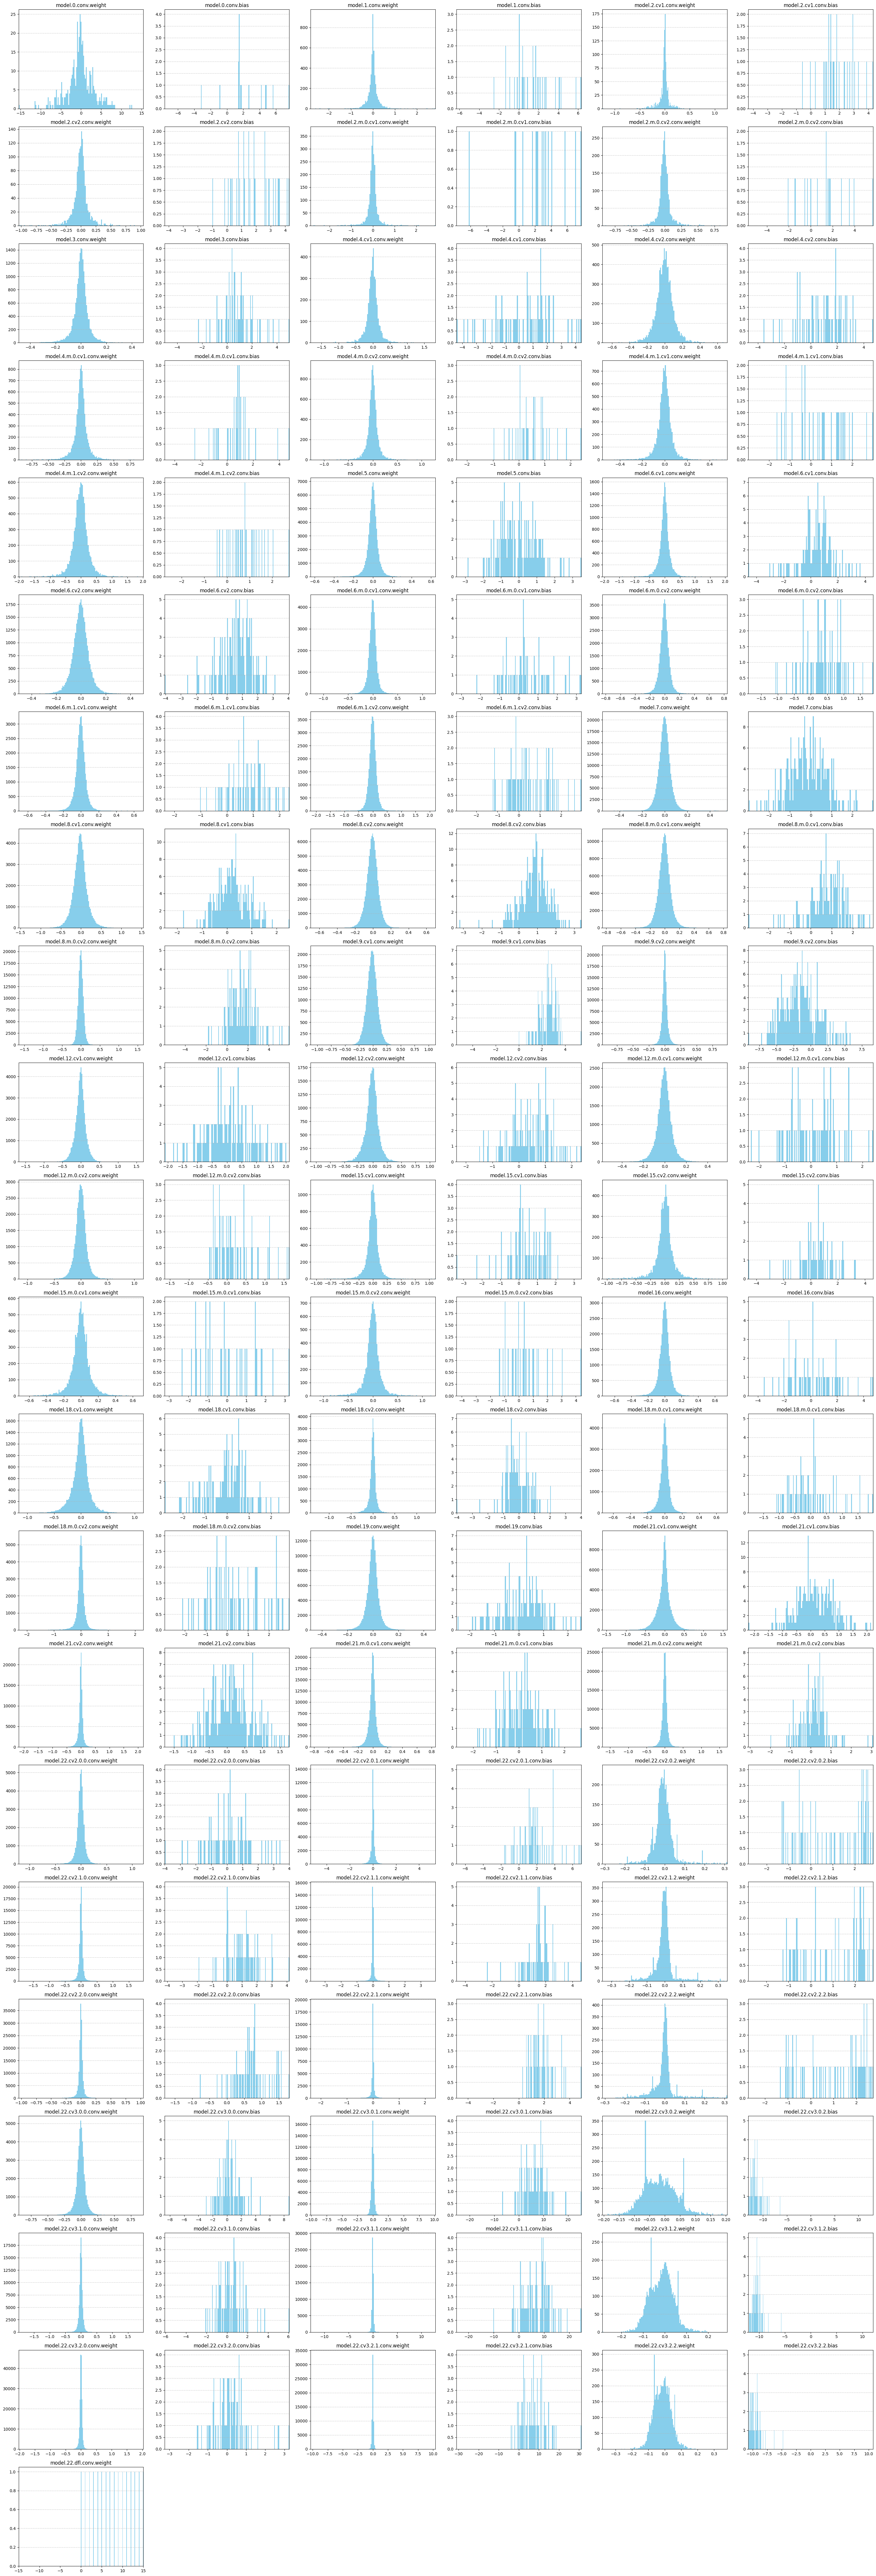

In [5]:
visualize_multiple_tensors(Qmodel.state_dict(), bins=128, n_cols=6)

## Activation

In [4]:
Nmodel = load_NPU_model('checkpoints/qat_091501.pth', device)

Loaded .pth state_dict
Start matching keys...

Matching keys done.



In [5]:
asc = ActivationStatsCollector(Nmodel, NConv2d)

In [6]:
# load trained NPU test_model and register hooks
run_batch = 1
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Nmodel(inputs, inference=True)
activation_stats = asc.get_stats()


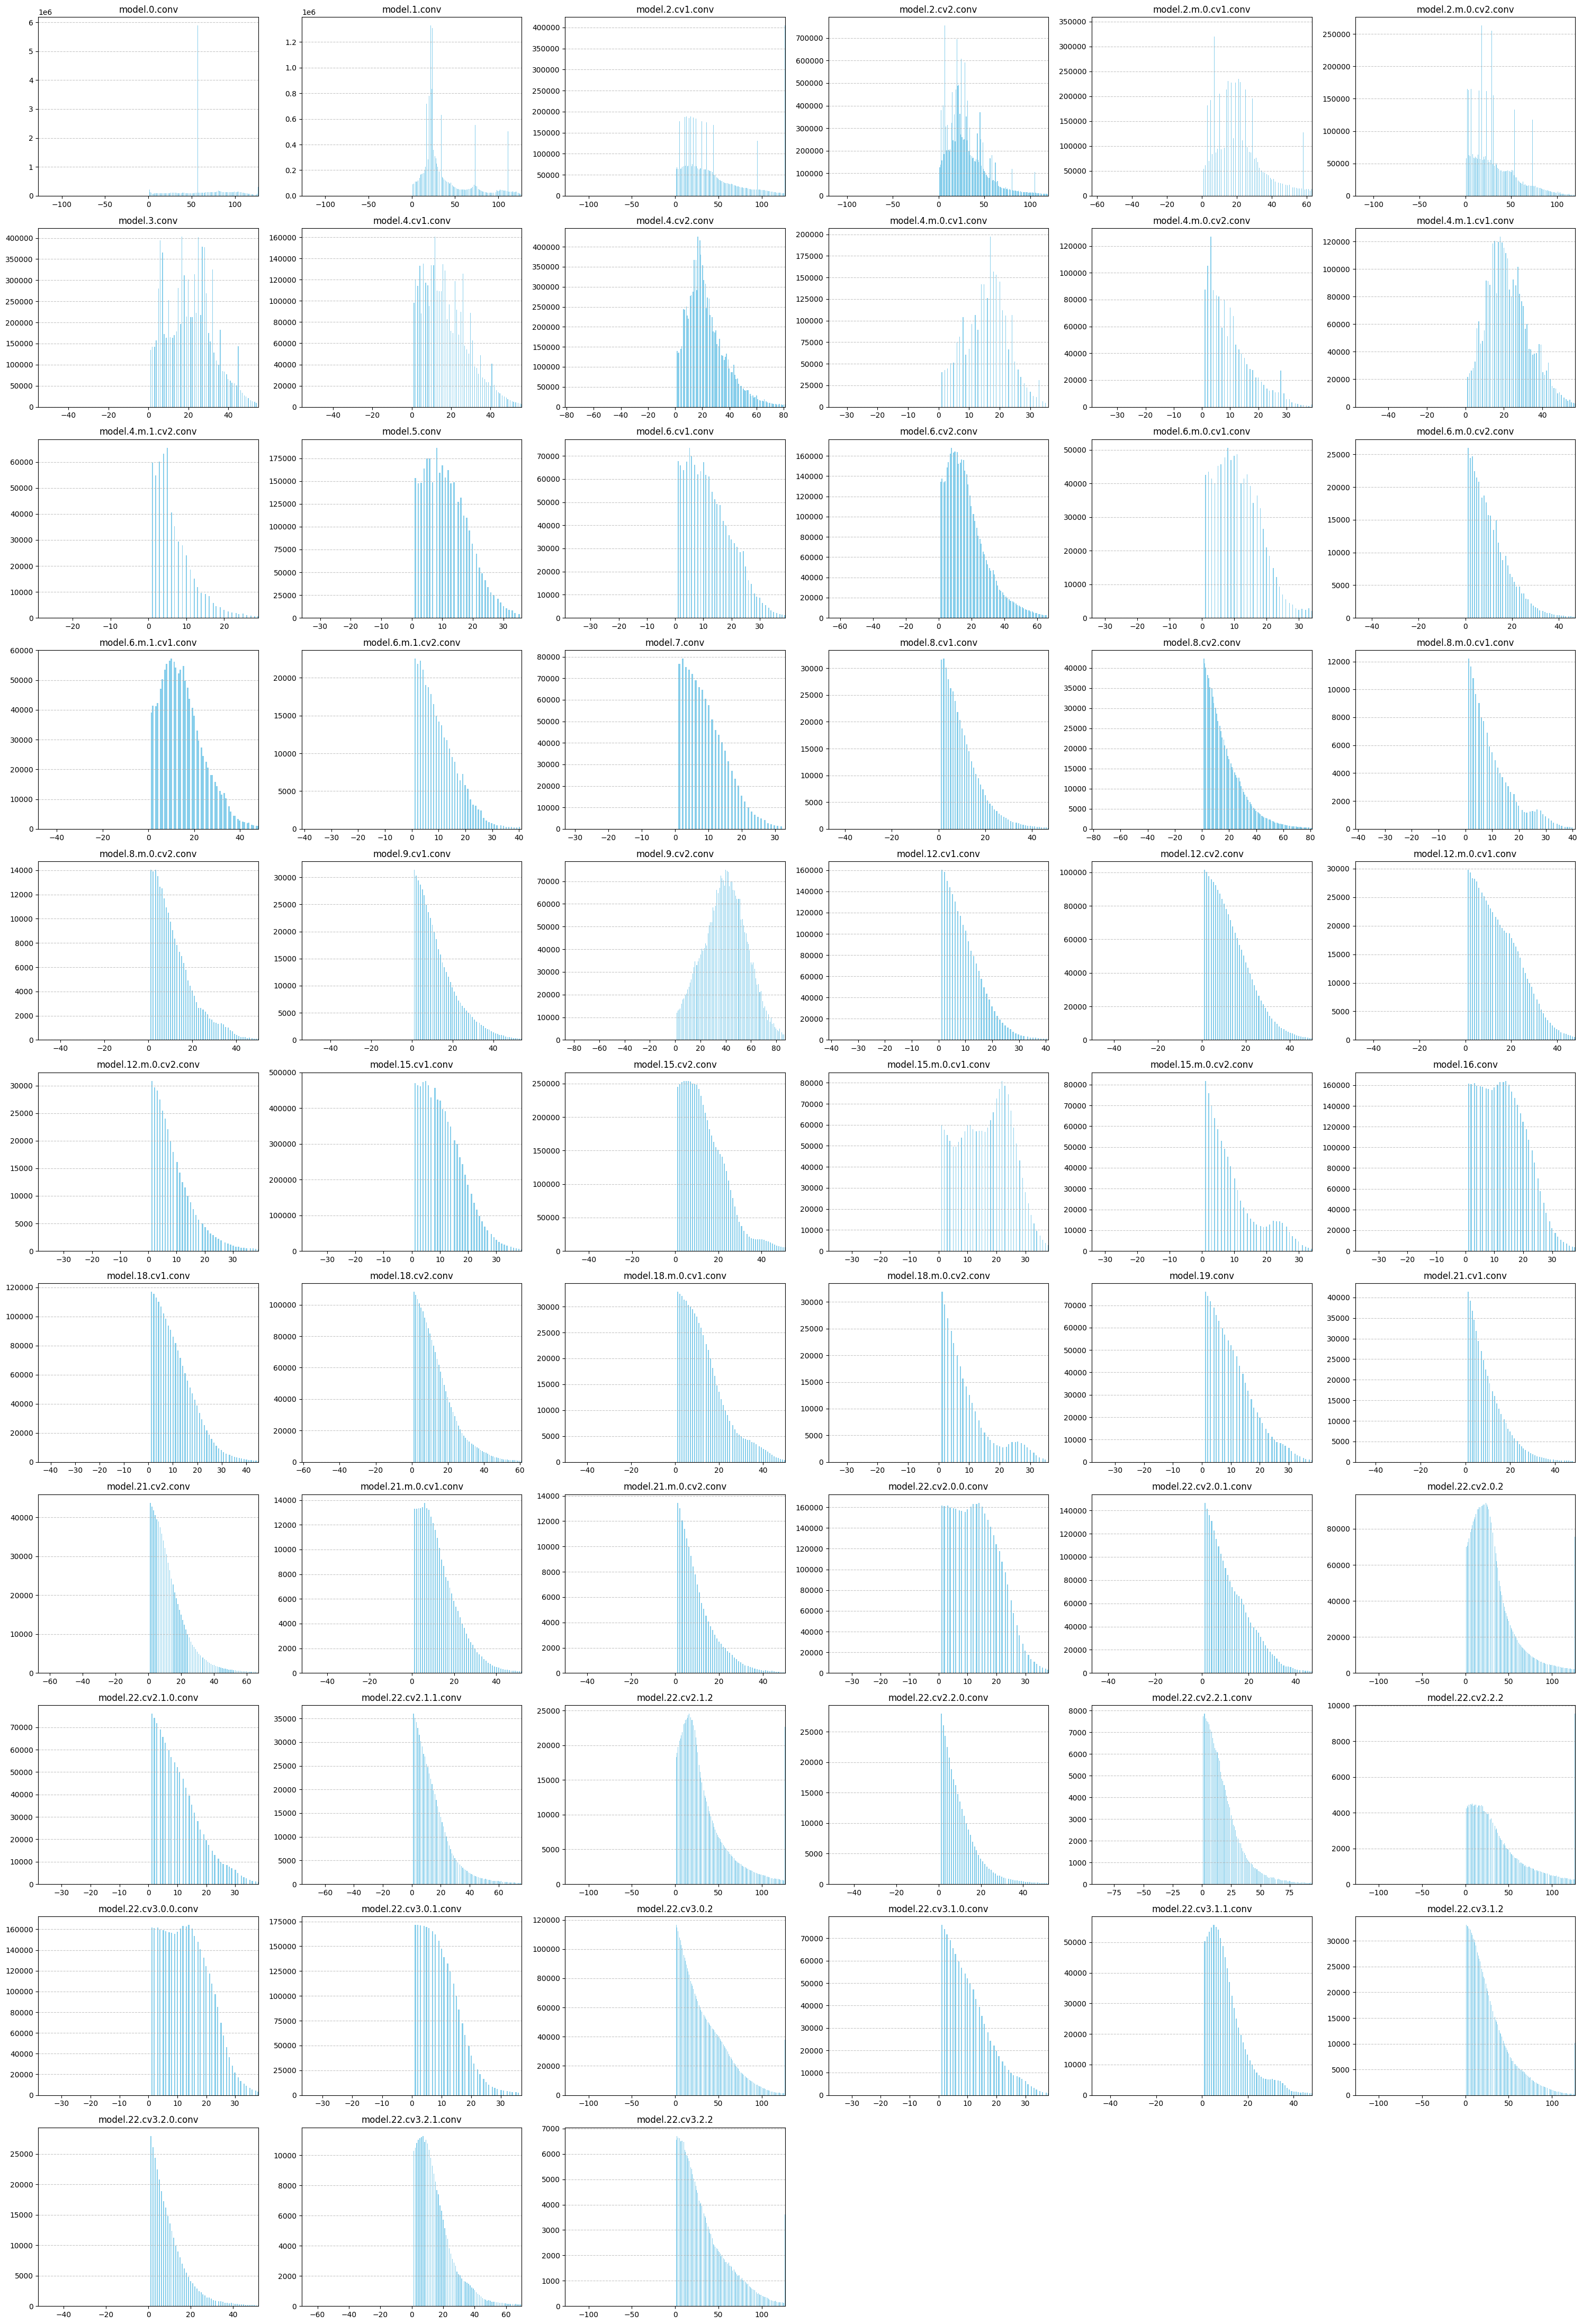

In [7]:
act_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    temp = acts.permute(1, 0, 2, 3).contiguous()
    zero_mask = acts != 0 
    act_stats[layer_name] = acts[zero_mask] if zero_mask.sum() > 0 else torch.tensor(0.0)

visualize_multiple_tensors(act_stats, bins=256, n_cols=6) # zero values are excluded

## QAT Act

Start matching keys...

Matching keys done.



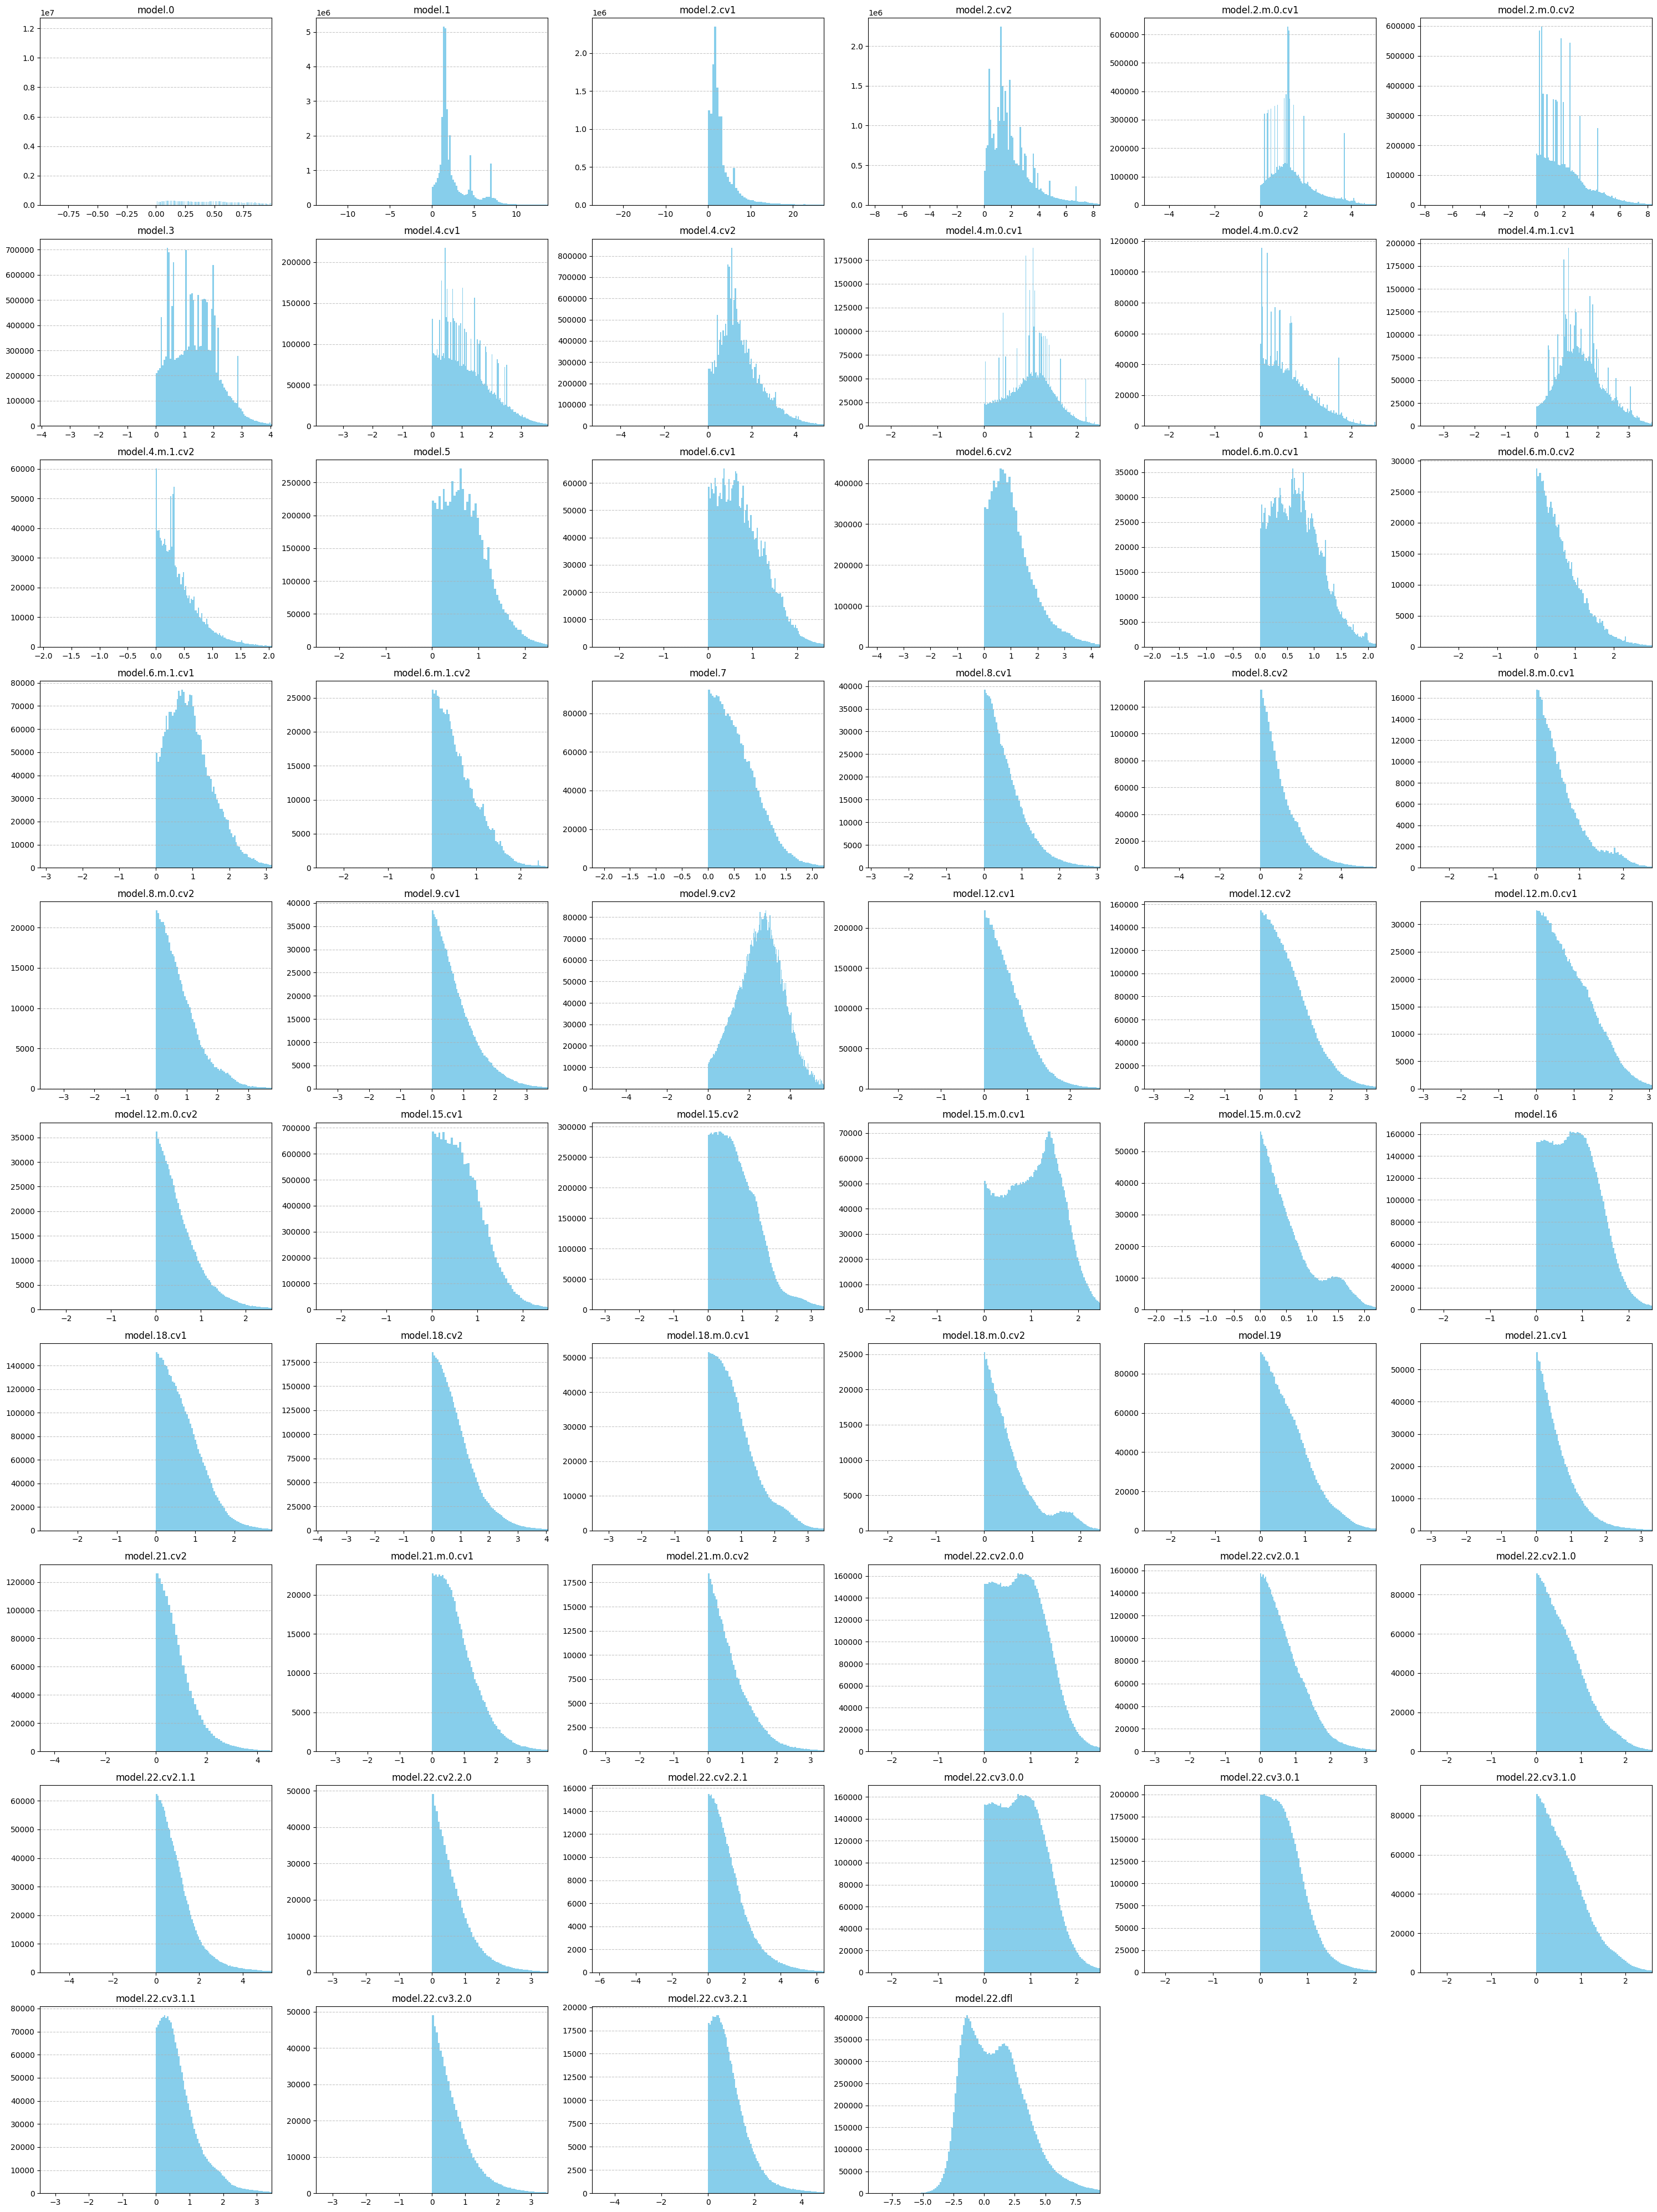

In [8]:
# load QAT model with quantization config
# with open('./config/qcfg_0928.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)

# Qmodel = load_model('checkpoints/qat_09272248.pt', device, model_type="qat", model_qcfg=loaded_cfg)

with open('./config/qcfg_0327.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

Qmodel = load_model('checkpoints/qat_09270730.pt', device, model_type="qat", model_qcfg=loaded_cfg)


asc = ActivationStatsCollector(Qmodel, (QConv, DFL))

run_batch = 2
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Qmodel(inputs, inference=True)
activation_stats = asc.get_stats()

act_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    try:
        temp = acts.permute(1, 0, 2, 3).contiguous()
        zero_mask = acts != 0 
        act_stats[layer_name] = acts[zero_mask] if zero_mask.sum() > 0 else torch.tensor(0.0)
    except:
        act_stats[layer_name] = acts

visualize_multiple_tensors(act_stats, bins=256, n_cols=6) # zero values are excluded

# Act2

In [73]:
s=7
[([f, -(2**s)/ (2 ** f), (2**s-1)/ (2 ** f)]) for f in range(-4, 8)]

[[-4, -2048.0, 2032.0],
 [-3, -1024.0, 1016.0],
 [-2, -512.0, 508.0],
 [-1, -256.0, 254.0],
 [0, -128.0, 127.0],
 [1, -64.0, 63.5],
 [2, -32.0, 31.75],
 [3, -16.0, 15.875],
 [4, -8.0, 7.9375],
 [5, -4.0, 3.96875],
 [6, -2.0, 1.984375],
 [7, -1.0, 0.9921875]]

In [74]:
s=8
[([f, 0, (2**s-1)/ (2 ** f)]) for f in range(-4, 9)]

[[-4, 0, 4080.0],
 [-3, 0, 2040.0],
 [-2, 0, 1020.0],
 [-1, 0, 510.0],
 [0, 0, 255.0],
 [1, 0, 127.5],
 [2, 0, 63.75],
 [3, 0, 31.875],
 [4, 0, 15.9375],
 [5, 0, 7.96875],
 [6, 0, 3.984375],
 [7, 0, 1.9921875],
 [8, 0, 0.99609375]]

In [ ]:
# load QAT model with quantization config


# with open('./config/qcfg_0928.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)
# Qmodel = load_model('checkpoints/qat_09272248.pt', device, model_type="qat", model_qcfg=loaded_cfg)

with open('./config/qcfg_0327.yaml') as f:
    loaded_cfg = yaml.safe_load(f)
Qmodel = load_model('checkpoints/qat_09270730.pt', device, model_type="qat", model_qcfg=loaded_cfg)

# with open('./config/quantization_config.yaml') as f:
    # loaded_cfg = yaml.safe_load(f)
# Qmodel = load_model('checkpoints/qat_091501.pth', device, model_type="qat", model_qcfg=loaded_cfg)

# with open('./config/quantization_config.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)
# Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)

NUM_BITS = 4

asc = ActivationStatsCollector(Qmodel, (QConv2d, DFL))

run_batch = 8
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Qmodel(inputs, inference=True)
activation_stats = asc.get_stats()

act_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    try:
        temp = acts.permute(1, 0, 2, 3).contiguous()
        zero_mask = acts != 0 
        act_stats[layer_name] = acts[zero_mask] if zero_mask.sum() > 0 else torch.tensor(0.0)
    except:
        act_stats[layer_name] = acts

import math
def get_frac_bits(num_ubits, x) -> int:
    exp = math.floor(math.log2((2**num_ubits - 1)/x)) 
    return exp 

af_list = []
names = list(act_stats.keys())
for i, name in enumerate(names):
    tensor = act_stats[name].flatten()
    max_val = tensor.kthvalue(int(tensor.numel() * 0.999)).values.item()
    f = get_frac_bits(NUM_BITS, max_val)
    af_list.append(f)
    
    print(f"{name:<25} | max={max_val:<7.2f} | frac_bits={f}")

Start matching keys...

Matching keys done.

model.0.conv              | max=0.99    | frac_bits=3
model.1.conv              | max=18.64   | frac_bits=-1
model.2.cv1.conv          | max=38.65   | frac_bits=-2
model.2.cv2.conv          | max=10.59   | frac_bits=0
model.2.m.0.cv1.conv      | max=6.39    | frac_bits=1
model.2.m.0.cv2.conv      | max=10.64   | frac_bits=0
model.3.conv              | max=5.19    | frac_bits=1
model.4.cv1.conv          | max=4.56    | frac_bits=1
model.4.cv2.conv          | max=6.32    | frac_bits=1
model.4.m.0.cv1.conv      | max=2.89    | frac_bits=2
model.4.m.0.cv2.conv      | max=3.03    | frac_bits=2
model.4.m.1.cv1.conv      | max=4.28    | frac_bits=1
model.4.m.1.cv2.conv      | max=2.65    | frac_bits=2
model.5.conv              | max=3.06    | frac_bits=2
model.6.cv1.conv          | max=3.28    | frac_bits=2
model.6.cv2.conv          | max=5.35    | frac_bits=1
model.6.m.0.cv1.conv      | max=2.66    | frac_bits=2
model.6.m.0.cv2.conv      | max=3.7

In [11]:
with open('./config/quantization_config.yaml') as f:
    loaded_cfg = yaml.safe_load(f)
Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)
with open('./config/qcfg_0327.yaml') as f:
    loaded_cfg = yaml.safe_load(f)
Qmodel2 = load_model('checkpoints/qat_09270730.pt', device, model_type="qat", model_qcfg=loaded_cfg)


w_stats = Qmodel.state_dict()
w_stats2 = Qmodel2.state_dict()

names = list(w_stats.keys())

wf_list = []

for i, name in enumerate(names):
    if 'weight' not in name:
        continue
    tensor = w_stats[name].flatten()
    max_val = tensor.kthvalue(int(tensor.numel() * 0.999)).values.item()
    f = get_frac_bits(NUM_BITS-1, max_val)
    wf_list.append(f)

    tensor = w_stats2[name].flatten()
    max_val2 = tensor.kthvalue(int(tensor.numel() * 0.999)).values.item()
    f2 = get_frac_bits(NUM_BITS-1, max_val2)
    print(f"{name:<35} | max={max_val:<7.2f}, {max_val2:<7.2f} | frac_bits={f}, frac_bits2={f2}")

Loaded .pth state_dict
Start matching keys...

Matching keys done.

Start matching keys...

Matching keys done.

model.0.conv.weight                 | max=12.17  , 12.16   | frac_bits=-1, frac_bits2=-1
model.1.conv.weight                 | max=1.96   , 1.97    | frac_bits=1, frac_bits2=1
model.2.cv1.conv.weight             | max=0.34   , 0.34    | frac_bits=4, frac_bits2=4
model.2.cv2.conv.weight             | max=0.65   , 0.65    | frac_bits=3, frac_bits2=3
model.2.m.0.cv1.conv.weight         | max=2.05   , 2.05    | frac_bits=1, frac_bits2=1
model.2.m.0.cv2.conv.weight         | max=0.60   , 0.61    | frac_bits=3, frac_bits2=3
model.3.conv.weight                 | max=0.27   , 0.27    | frac_bits=4, frac_bits2=4
model.4.cv1.conv.weight             | max=1.17   , 1.17    | frac_bits=2, frac_bits2=2
model.4.cv2.conv.weight             | max=0.46   , 0.46    | frac_bits=3, frac_bits2=3
model.4.m.0.cv1.conv.weight         | max=0.48   , 0.48    | frac_bits=3, frac_bits2=3
model.4.m.0.cv2

### Q Config Gen

In [12]:
import copy


def bottleneck_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def c2f_qcfg_gen(cfg, n):
    ret = {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }
    for i in range(n):
        ret[f"m.{i}"] = bottleneck_qcfg_gen(cfg)
    return ret

def sppf_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def detect_qcfg_gen(cfg):
    return {
        "cv2.0": cfg.pop(0),
        "cv2.1": cfg.pop(0),
        "cv2.2": cfg.pop(0),

        "cv3.0": cfg.pop(0),
        "cv3.1": cfg.pop(0),
        "cv3.2": cfg.pop(0),
    }

a = copy.deepcopy(af_list) # activation fraction bits, sequential
w = copy.deepcopy(wf_list) # weight fraction bits, sequential
num_bits = NUM_BITS

# note: config format: [num_bits, w_fraction_bits, a_fraction_bits]
quantization_config = {
    "layer_0": [num_bits, w.pop(0), a.pop(0)],
    "layer_1": [num_bits, w.pop(0), a.pop(0)],
    "layer_2": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_3": [num_bits, w.pop(0), a.pop(0)],
    "layer_4": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv2
    ], 2),
    "layer_5": [num_bits, w.pop(0), a.pop(0)],
    "layer_6": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv2
    ], 2),
    "layer_7": [num_bits, w.pop(0), a.pop(0)],
    "layer_8": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_9": sppf_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
    ]),
    "layer_12": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_15": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_16": [num_bits, w.pop(0), a.pop(0)],
    "layer_18": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_19": [num_bits, w.pop(0), a.pop(0)],
    "layer_21": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_22": detect_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv2.0
        [num_bits, w.pop(0), a.pop(0)], # cv2.1
        [num_bits, w.pop(0), a.pop(0)], # cv2.2
        [num_bits, w.pop(0), a.pop(0)], # cv3.0
        [num_bits, w.pop(0), a.pop(0)], # cv3.1
        [num_bits, w.pop(0), a.pop(0)], # cv3.2
    ]),
}

import yaml


# YAML save 
class MyDumper(yaml.SafeDumper):
    pass

def represent_list_flow(dumper, data):
    return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)

MyDumper.add_representer(list, represent_list_flow)

from datetime import datetime

# Model Save
now = datetime.now()
formatted = now.strftime("%m%d%H%M")

name = 'qcfg_1'
# save
with open(f'./config/qcfg_{formatted}.yaml', 'w') as f:
    yaml.dump(quantization_config, f, Dumper=MyDumper, sort_keys=False)

# load
with open(f'./config/qcfg_{formatted}.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

# check
print(loaded_cfg)



{'layer_0': [4, -1, 3], 'layer_1': [4, 1, -1], 'layer_2': {'cv1': [4, 4, -2], 'cv2': [4, 3, 0], 'm.0': {'cv1': [4, 1, 1], 'cv2': [4, 3, 0]}}, 'layer_3': [4, 4, 1], 'layer_4': {'cv1': [4, 2, 1], 'cv2': [4, 3, 1], 'm.0': {'cv1': [4, 3, 2], 'cv2': [4, 3, 2]}, 'm.1': {'cv1': [4, 4, 1], 'cv2': [4, 2, 2]}}, 'layer_5': [4, 4, 2], 'layer_6': {'cv1': [4, 3, 2], 'cv2': [4, 4, 1], 'm.0': {'cv1': [4, 3, 2], 'cv2': [4, 4, 2]}, 'm.1': {'cv1': [4, 4, 1], 'cv2': [4, 3, 2]}}, 'layer_7': [4, 4, 2], 'layer_8': {'cv1': [4, 3, 1], 'cv2': [4, 4, 0], 'm.0': {'cv1': [4, 4, 2], 'cv2': [4, 4, 1]}}, 'layer_9': {'cv1': [4, 4, 1], 'cv2': [4, 4, 1]}, 'layer_12': {'cv1': [4, 3, 1], 'cv2': [4, 3, 1], 'm.0': {'cv1': [4, 4, 2], 'cv2': [4, 3, 2]}}, 'layer_15': {'cv1': [4, 3, 2], 'cv2': [4, 3, 1], 'm.0': {'cv1': [4, 3, 2], 'cv2': [4, 3, 2]}}, 'layer_16': [4, 4, 2], 'layer_18': {'cv1': [4, 3, 2], 'cv2': [4, 3, 1], 'm.0': {'cv1': [4, 4, 1], 'cv2': [4, 2, 2]}}, 'layer_19': [4, 4, 2], 'layer_21': {'cv1': [4, 3, 1], 'cv2': [4

# Outlier Analysis

# Pruning

## POZ Analysis

In [ ]:
# load QAT model with quantization config


# with open('./config/qcfg_0928.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)
# Qmodel = load_model('checkpoints/qat_09272248.pt', device, model_type="qat", model_qcfg=loaded_cfg)

with open('./config/qcfg_0327.yaml') as f:
    loaded_cfg = yaml.safe_load(f)
Qmodel = load_model('checkpoints/qat_09270730.pt', device, model_type="qat", model_qcfg=loaded_cfg)

# with open('./config/quantization_config.yaml') as f:
    # loaded_cfg = yaml.safe_load(f)
# Qmodel = load_model('checkpoints/qat_091501.pth', device, model_type="qat", model_qcfg=loaded_cfg)

# with open('./config/quantization_config.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)
# Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)

asc = ActivationStatsCollector(Qmodel, (QConv2d))

run_batch = 1
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Qmodel(inputs, inference=True)
activation_stats = asc.get_stats()

poz_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    # try:
    td_zero = (acts == 0)
    poz_stats[layer_name] = td_zero.float().mean(dim=(0, 2, 3)) * 100
    # except:
    #     td_zero = (temp == 0)
    #     poz_stats[layer_name] = td_zero.float().mean(dim=0) * 100

def topk_poz(x, p=0.5):

    k = int(x.numel() * p)  # 6*0.5=3

    # 하위 k개 index
    values, idx = torch.topk(x, k=k, largest=False)
    # print("Indices:", idx)        # tensor([3])
    # print("Values:", values)      # tensor([0.1])

    # Threshold = k번째 값
    threshold = values.max()      # 하위 30%에서 가장 큰 값
    # print("Threshold:", threshold) # tensor(0.1)
    return idx, threshold

af_list = []
names = list(poz_stats.keys())
for i, name in enumerate(names):
    poz = poz_stats[name]
    idx, threshold = topk_poz(poz)
    
    print(f"top5: {str(idx[:5]):<40} | thres={threshold:<7.2f} debug:{idx.shape}")

Start matching keys...

Matching keys done.

top5: tensor([0])                              | thres=0.42   
top5: tensor([ 4,  6, 15, 11,  5])             | thres=9.07   
top5: tensor([30, 25,  9, 31,  2])             | thres=33.59  
top5: tensor([32, 16, 36, 47, 34])             | thres=7.86   
top5: tensor([ 0,  9, 15, 13,  4])             | thres=11.64  
top5: tensor([15,  4,  5,  1,  3])             | thres=31.64  
top5: tensor([ 4,  2, 12, 21, 25])             | thres=17.61  
top5: tensor([ 9,  2, 27, 45, 39])             | thres=44.28  
top5: tensor([103, 123,  71,  36, 100])        | thres=2.13   
top5: tensor([ 4, 27,  7, 10, 29])             | thres=4.26   
top5: tensor([29, 20,  0, 31,  6])             | thres=62.11  
top5: tensor([ 7,  4, 27, 24, 10])             | thres=0.71   
top5: tensor([ 7, 12,  0, 27, 28])             | thres=87.29  
top5: tensor([ 7, 17, 38,  1, 21])             | thres=47.47  
top5: tensor([ 34,  89,  95, 126,  71])        | thres=66.95  
top5: tens

In [60]:
af_list = []
names = list(poz_stats.keys())
for i, name in enumerate(names):
    poz = poz_stats[name]
    idx, threshold = topk_poz(poz, p=0.75)

    print(f"name: {name:<25} | top5: {str(idx[:5]):<35} | thres={threshold:<7.2f} | debug:{idx.shape}")

name: model.0.conv              | top5: tensor([0, 1])                      | thres=0.79    | debug:torch.Size([2])
name: model.1.conv              | top5: tensor([ 4,  6, 15, 11,  5])        | thres=67.67   | debug:torch.Size([12])
name: model.2.cv1.conv          | top5: tensor([30, 25,  9, 31,  2])        | thres=74.41   | debug:torch.Size([24])
name: model.2.cv2.conv          | top5: tensor([32, 16, 36, 47, 34])        | thres=22.63   | debug:torch.Size([36])
name: model.2.m.0.cv1.conv      | top5: tensor([ 0,  9, 15, 13,  4])        | thres=24.46   | debug:torch.Size([12])
name: model.2.m.0.cv2.conv      | top5: tensor([15,  4,  5,  1,  3])        | thres=37.57   | debug:torch.Size([12])
name: model.3.conv              | top5: tensor([ 4,  2, 12, 21, 25])        | thres=40.98   | debug:torch.Size([24])
name: model.4.cv1.conv          | top5: tensor([ 2,  9, 27, 45, 39])        | thres=80.21   | debug:torch.Size([48])
name: model.4.cv2.conv          | top5: tensor([103, 123,  71,  6

In [ ]:
# import copy
# from typing import Union, List
# import torch
# import torch.nn as nn

# def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
#     """Calculate number of hidden channels to preserve after pruning.
#     preserve_rate = 1 - prune_ratio
#     """
    
#     return int(round(channels * (1 - prune_ratio)))

# def get_channel_importance(weight: Union[torch.Tensor, List[torch.Tensor]], layer_type: str='conv') -> torch.Tensor:
#     """
#     Compute hidden unit importance considering both fc1 and fc2 weights.
#     """

#     layer_type = layer_type.lower()
#     if layer_type == "conv":
#         # For convolutional layers, get input channel importance
#         importance = get_input_channel_importance(weight)
#     else:
#         raise ValueError(f"Unknown layer type: {layer_type}")
#     return importance
#     # fc1 row L2 norm (input -> hidden)
#     fc1_importance = torch.norm(fc1_weight.detach(), p=2, dim=1)  # [hidden_dim]
#     # fc2 column L2 norm (hidden -> output)
#     fc2_importance = torch.norm(fc2_weight.detach(), p=2, dim=0)  # [hidden_dim]
#     # importance = fc1_importance * fc2_importance
#     importance = fc1_importance * fc2_importance

# # function to sort the channels from important to non-important
# def get_input_channel_importance(weight):
#     in_channels = weight.shape[1]
#     importances = []
#     # compute the importance for each input channel
#     for i_c in range(weight.shape[1]):
#         channel_weight = weight.detach()[:, i_c]
#         ##################### YOUR CODE STARTS HERE #####################
#         importance = torch.norm(channel_weight)
#         ##################### YOUR CODE ENDS HERE #####################
#         importances.append(importance.view(1))
#     return torch.cat(importances)

# @torch.no_grad()
# def mlp_channel_prune(model: nn.Module,
#                   prune_ratio: Union[List[float], float]) -> nn.Module:
#     """
#     Prune MLPs (two Linear layers: fc1, fc2).
#     Only hidden dimension is pruned.
#     """
#     model = copy.deepcopy(model)  # prevent overwrite
#     # get all Mlp modules
#     all_mlps = [module for stage in model.stages for block in stage.blocks for module in block.modules() if isinstance(module, Mlp)]

#     if isinstance(prune_ratio, float):
#         prune_ratio = [prune_ratio] * len(all_mlps)

#     for i, p_ratio in enumerate(prune_ratio):
#         mlp = all_mlps[i]
#         fc1, fc2 = mlp.fc1, mlp.fc2

#         # get number of hidden channels to keep
#         hidden_dim = fc1.out_features
#         n_keep = get_num_channels_to_keep(hidden_dim, p_ratio)

#         # calculate importance and get indices to keep
#         importance = get_hidden_unit_importance(fc1.weight, fc2.weight)  # [hidden_dim]
#         _, indices = torch.topk(importance, k=n_keep, largest=True)
#         indices = indices.sort().values 

#         # fc1: prune output channels
#         fc1.weight.set_(fc1.weight.detach()[indices, :])
#         if fc1.bias is not None:
#             fc1.bias.set_(fc1.bias.detach()[indices])

#         # fc2: prune input channels (no pruning for bias)
#         fc2.weight.set_(fc2.weight.detach()[:, indices])

#     return model

# @torch.no_grad()
# def apply_channel_sorting(model):
#     model = copy.deepcopy(model)  # do not modify the original model
#     # fetch all the conv and bn layers from the backbone
#     all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
#     all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
#     # iterate through conv layers
#     for i_conv in range(len(all_convs) - 1):
#         # each channel sorting index, we need to apply it to:
#         # - the output dimension of the previous conv
#         # - the previous BN layer
#         # - the input dimension of the next conv (we compute importance here)
#         prev_conv = all_convs[i_conv]
#         prev_bn = all_bns[i_conv]
#         next_conv = all_convs[i_conv + 1]
#         # note that we always compute the importance according to input channels
#         importance = get_input_channel_importance(next_conv.weight)
#         # sorting from large to small
#         sort_idx = torch.argsort(importance, descending=True)

#         # apply to previous conv and its following bn
#         prev_conv.weight.copy_(torch.index_select(
#             prev_conv.weight.detach(), 0, sort_idx))
#         for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
#             tensor_to_apply = getattr(prev_bn, tensor_name)
#             tensor_to_apply.copy_(
#                 torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
#             )

#         # apply to the next conv input (hint: one line of code)
#         ##################### YOUR CODE STARTS HERE #####################
#         next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
#         ##################### YOUR CODE ENDS HERE #####################

#     return model

# Demo

In [6]:
demo(train_loader, Nmodel, device, coco_id2label, label2coco_category, iou_threshold=0.3)

In [15]:
demo(train_loader, Qmodel, device, coco_id2label, label2coco_category, iou_threshold=0.7)

# Quantization Config Generator

In [ ]:
def bottleneck_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def c2f_qcfg_gen(cfg, n):
    ret = {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }
    for i in range(n):
        ret[f"m.{i}"] = bottleneck_qcfg_gen(cfg)
    return ret

def sppf_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def detect_qcfg_gen(cfg):
    return {
        "cv2.0": cfg.pop(0),
        "cv2.1": cfg.pop(0),
        "cv2.2": cfg.pop(0),

        "cv3.0": cfg.pop(0),
        "cv3.1": cfg.pop(0),
        "cv3.2": cfg.pop(0),
    }

# note: config format: [num_bits, w_fraction_bits, a_fraction_bits]
quantization_config = {
    "layer_0": [8,3,7],
    "layer_1": [8,6,4],
    "layer_2": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             ], 1),
    "layer_3": [8,6,4],
    "layer_4": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             [8,6,4], # bottleneck 1.cv1
                             [8,6,4], # bottleneck 1.cv2
                             ], 2),
    "layer_5": [8,6,4],
    "layer_6": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             [8,6,4], # bottleneck 1.cv1
                             [8,6,4], # bottleneck 1.cv2
                             ], 2),
    "layer_7": [8,6,4],
    "layer_8": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             ], 1),
    "layer_9": sppf_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              ]),
    "layer_12": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_15": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_16": [8,6,4],
    "layer_18": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_19": [8,6,4],
    "layer_21": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),

    "layer_22": detect_qcfg_gen([[8,6,4], # cv2.0
                                 [8,6,4], # cv2.1
                                 [8,7,4], # cv2.2
                                 [8,6,4], # cv3.0
                                 [8,6,4], # cv3.1
                                 [8,7,3], # cv3.2
                                 ]),
}

import yaml


# YAML save 
class MyDumper(yaml.SafeDumper):
    pass

def represent_list_flow(dumper, data):
    return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)

MyDumper.add_representer(list, represent_list_flow)

# save
with open('./config/quantization_config.yaml', 'w') as f:
    yaml.dump(quantization_config, f, Dumper=MyDumper, sort_keys=False)

# load
with open('./config/quantization_config.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

# check
print(loaded_cfg)

